In [93]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [54]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


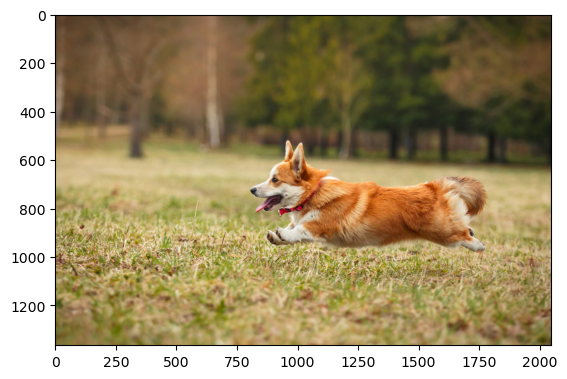

In [55]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")

# Show the image
plt.imshow(img.permute(1, 2, 0))

In [56]:
img

tensor([[[ 79,  80,  80,  ...,  75,  75,  76],
         [ 79,  80,  80,  ...,  75,  75,  76],
         [ 79,  80,  80,  ...,  75,  75,  76],
         ...,
         [121, 121, 122,  ...,  97,  96,  96],
         [121, 121, 122,  ...,  97,  97,  96],
         [121, 121, 122,  ...,  98,  97,  97]],

        [[ 52,  53,  53,  ...,  55,  55,  54],
         [ 52,  53,  53,  ...,  55,  55,  54],
         [ 52,  53,  53,  ...,  55,  55,  54],
         ...,
         [103, 103, 104,  ...,  82,  81,  81],
         [103, 103, 104,  ...,  82,  82,  81],
         [103, 103, 104,  ...,  83,  82,  82]],

        [[ 35,  36,  36,  ...,  30,  30,  30],
         [ 35,  36,  36,  ...,  30,  30,  30],
         [ 35,  36,  36,  ...,  30,  30,  30],
         ...,
         [ 37,  37,  38,  ...,  43,  42,  42],
         [ 37,  37,  38,  ...,  43,  43,  42],
         [ 37,  37,  38,  ...,  44,  43,  43]]], dtype=torch.uint8)

In [82]:
# Use sklearn to normalize the image and store the transform to be used later
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img


MinMaxScaler()

In [83]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [85]:
img_scaled.shape

torch.Size([3, 1365, 2048])

In [90]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

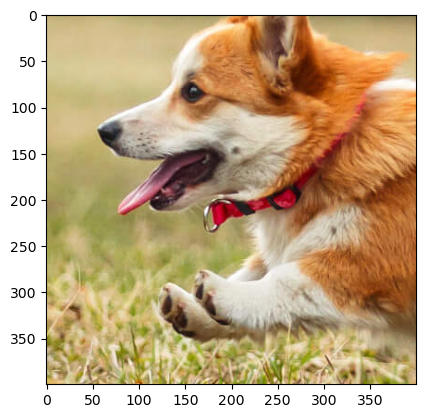

In [92]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 750, 400, 400)

# Plot the crop
plt.imshow(crop.permute(1, 2, 0))

In [96]:
crop = crop.to(device)

In [88]:
# Get the dimensions of the image tensor
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 400 400


In [97]:
# Create a coordinate dataset from the image
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height* width, 2) and torch.tensor containing the (num_channels)
    """
    
    num_channels, height, width = crop.shape
    
    # Create a 2D grid of (x,y) coordinates
    x_coords = torch.arange(width).repeat(height, 1)
    y_coords = torch.arange(height).repeat(width, 1).t()
    x_coords = x_coords.reshape(-1)
    y_coords = y_coords.reshape(-1)
    
    # Combine the x and y coordinates into a single tensor
    X = torch.stack([x_coords, y_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)
    
    # Create a tensor containing the image pixel values
    Y = img.reshape(-1, num_channels).float().to(device)
    return X, Y

In [110]:
dog_X, dog_Y = create_coordinate_map(crop)

dog_X.shape, dog_Y.shape

# MinMaxScaler
scaler_X = preprocessing.MinMaxScaler().fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()

In [111]:
dog_X_scaled.shape, dog_Y.shape

(torch.Size([160000, 2]), torch.Size([160000, 3]))

In [112]:
# Create a MLP with 5 hidden layers with 256 neurons each and ReLU activations.
# Input is (x, y) and output is (r, g, b) or (g) for grayscale

class NN(nn.Module):
    def __init__(self, activation=torch.sin, n_out=1):
        super().__init__()
        self.activation = activation
        self.fc1 = nn.Linear(2, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 256)
        self.fc6 = nn.Linear(256, n_out) #gray scale image (1) or RGB (3)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.activation(self.fc5(x))
        return self.fc6(x)

In [113]:
nns = {}
nns["dog"] = {}
nns["dog"]["relu"] = NN(activation=torch.relu, n_out=3).to(device)
nns["dog"]["sin"] = NN(activation=torch.sin, n_out=3).to(device)

In [115]:
nns["dog"]["relu"](dog_X_scaled).shape, nns["dog"]["sin"](dog_X).shape

(torch.Size([160000, 3]), torch.Size([160000, 3]))

In [116]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        
        
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()


In [117]:
train(nns["dog"]["relu"], lr=0.001, X=dog_X_scaled, Y=dog_Y, epochs=2000)

Epoch 0 loss: 0.354026
Epoch 100 loss: 0.035635
Epoch 200 loss: 0.034608
Epoch 300 loss: 0.033201
Epoch 400 loss: 0.031922
Epoch 500 loss: 0.031077
Epoch 600 loss: 0.029891
Epoch 700 loss: 0.027882
Epoch 800 loss: 0.027325
Epoch 900 loss: 0.026375
Epoch 1000 loss: 0.024951
Epoch 1100 loss: 0.026354
Epoch 1200 loss: 0.023316
Epoch 1300 loss: 0.023240
Epoch 1400 loss: 0.022308
Epoch 1500 loss: 0.022254
Epoch 1600 loss: 0.021510
Epoch 1700 loss: 0.021131
Epoch 1800 loss: 0.021309
Epoch 1900 loss: 0.022225


0.019975468516349792

In [1]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(num_channels, height, width)
        outputs = outputs.permute(1, 2, 0)
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(outputs.cpu())
    ax[0].set_title("Reconstructed Image")
    ax[1].imshow(original_img.cpu().permute(1, 2, 0))
    ax[1].set_title("Original Image")
    fig.suptitle(title)
    fig.tight_layout()

plot_reconstructed_and_original_image(crop, nns["dog"]["relu"], dog_X_scaled)

NameError: name 'train' is not defined

In [121]:
imgs_dog_sin = train(nns["dog"]["sin"], lr=0.001, X=dog_X, Y=dog_Y, epochs=2000)

Epoch 0 loss: 0.352272
Epoch 100 loss: 0.033535
Epoch 200 loss: 0.008760
Epoch 300 loss: 0.006285
Epoch 400 loss: 0.004556
Epoch 500 loss: 0.004432
Epoch 600 loss: 0.003576
Epoch 700 loss: 0.003374
Epoch 800 loss: 0.003095
Epoch 900 loss: 0.003033
Epoch 1000 loss: 0.002916
Epoch 1100 loss: 0.002813
Epoch 1200 loss: 0.002796
Epoch 1300 loss: 0.002645
Epoch 1400 loss: 0.002818
Epoch 1500 loss: 0.002530
Epoch 1600 loss: 0.002473
Epoch 1700 loss: 0.002420
Epoch 1800 loss: 0.002606
Epoch 1900 loss: 0.002424


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


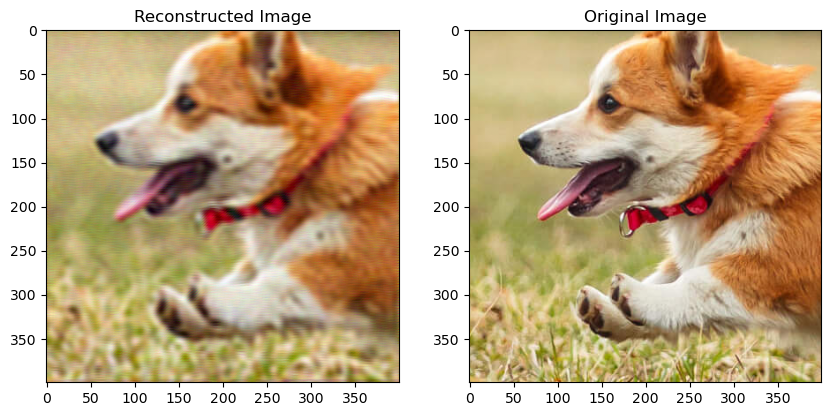

In [122]:
plot_reconstructed_and_original_image(crop, nns["dog"]["sin"], dog_X)

In [134]:
context_lengths = [5, 10, 100, 1000, 10000, len(dog_X)][:4]

In [136]:
# Now, reconstruct the image using a sine activation function with varying number of context points (subsampled from the original image)

test_nets_sirens = {}


# shuffled index
sh_index = torch.randperm(dog_X_scaled.shape[0])

# Shuffle the dataset
dog_X_sh = dog_X_scaled[sh_index]
dog_Y_sh = dog_Y[sh_index]

print(dog_X_sh.shape, dog_Y_sh.shape)
loss_context = {"train": {}, "test": {}}
for num_context in context_lengths:
    print("="*50)
    print(f"Number of context points: {num_context}")
    test_nets_sirens[num_context] = NN(activation=torch.sin, n_out=3).to(device)
    loss_context["train"][num_context] = train(test_nets_sirens[num_context], lr=0.001, X=dog_X_sh[:num_context], 
                                               Y=dog_Y_sh[:num_context], epochs=2000, verbose=False)
    # Find the loss on the test set
    with torch.no_grad():
        loss_context["test"][num_context] = nn.MSELoss()(test_nets_sirens[num_context](dog_X_scaled), dog_Y).item()
    print(f"Test loss: {loss_context['test'][num_context]:.6f}")


torch.Size([160000, 2]) torch.Size([160000, 3])
Number of context points: 5
Test loss: 0.068152
Number of context points: 10
Test loss: 0.079294
Number of context points: 100
Test loss: 0.081999
Number of context points: 1000
Test loss: 0.029439


In [137]:
loss_context["train"]

{5: 1.3855584431524126e-12,
 10: 3.131295667202494e-09,
 100: 0.005144745111465454,
 1000: 0.018522564321756363}

In [138]:
dog_X[:10], dog_X_scaled[:10]

(tensor([[0., 0.],
         [1., 0.],
         [2., 0.],
         [3., 0.],
         [4., 0.],
         [5., 0.],
         [6., 0.],
         [7., 0.],
         [8., 0.],
         [9., 0.]], device='cuda:0'),
 tensor([[0.0000, 0.0000],
         [0.0025, 0.0000],
         [0.0050, 0.0000],
         [0.0075, 0.0000],
         [0.0100, 0.0000],
         [0.0125, 0.0000],
         [0.0150, 0.0000],
         [0.0175, 0.0000],
         [0.0201, 0.0000],
         [0.0226, 0.0000]], device='cuda:0'))

In [139]:
dog_Y[:10]

tensor([[0.7686, 0.7686, 0.7647],
        [0.7608, 0.7608, 0.7608],
        [0.7569, 0.7569, 0.7529],
        [0.7529, 0.7373, 0.7373],
        [0.7373, 0.7373, 0.7373],
        [0.7373, 0.7373, 0.7373],
        [0.7255, 0.7255, 0.7294],
        [0.7294, 0.7333, 0.7333],
        [0.7333, 0.7373, 0.7490],
        [0.7490, 0.7490, 0.7490]], device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of context points: 5
Number of context points: 10
Number of context points: 100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of context points: 1000


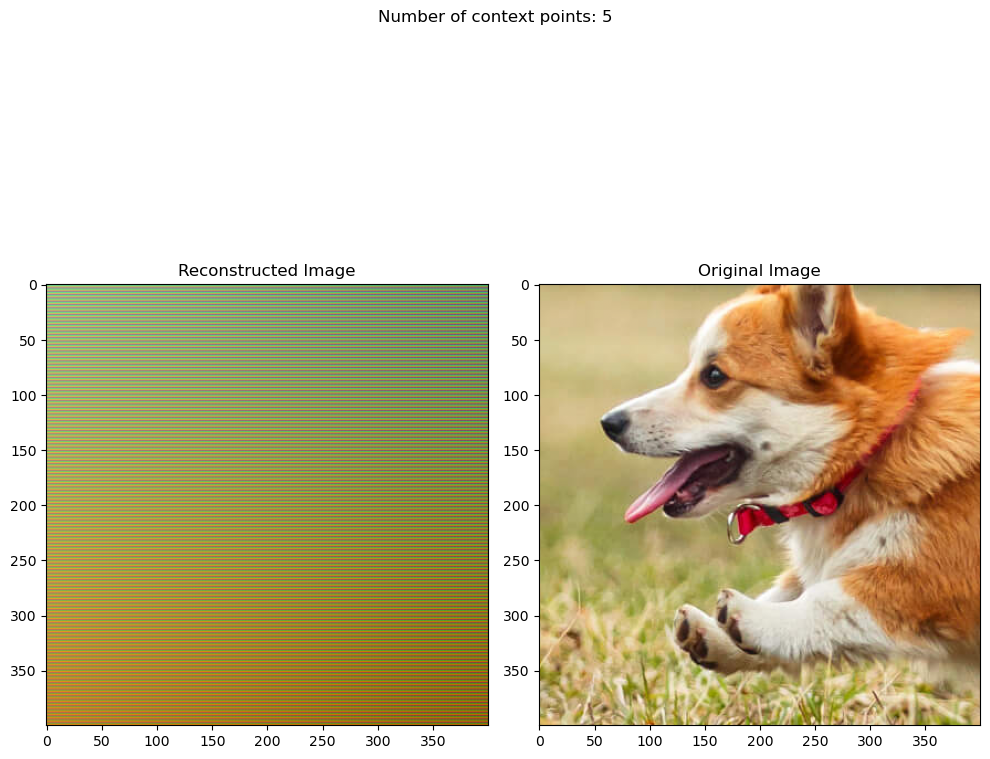

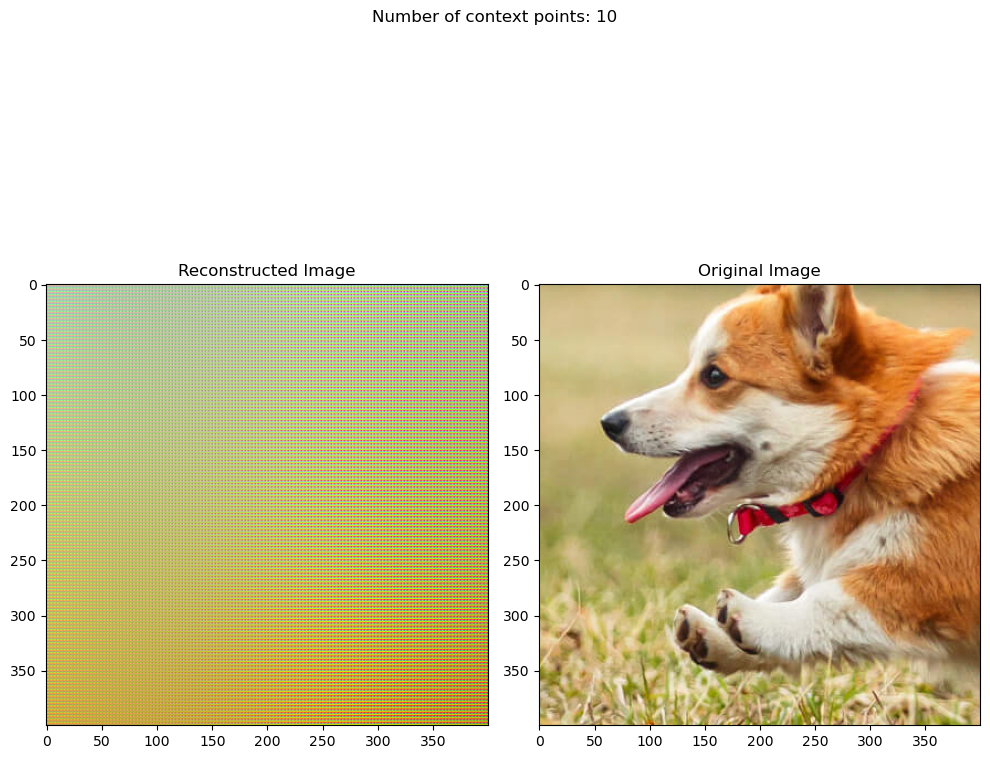

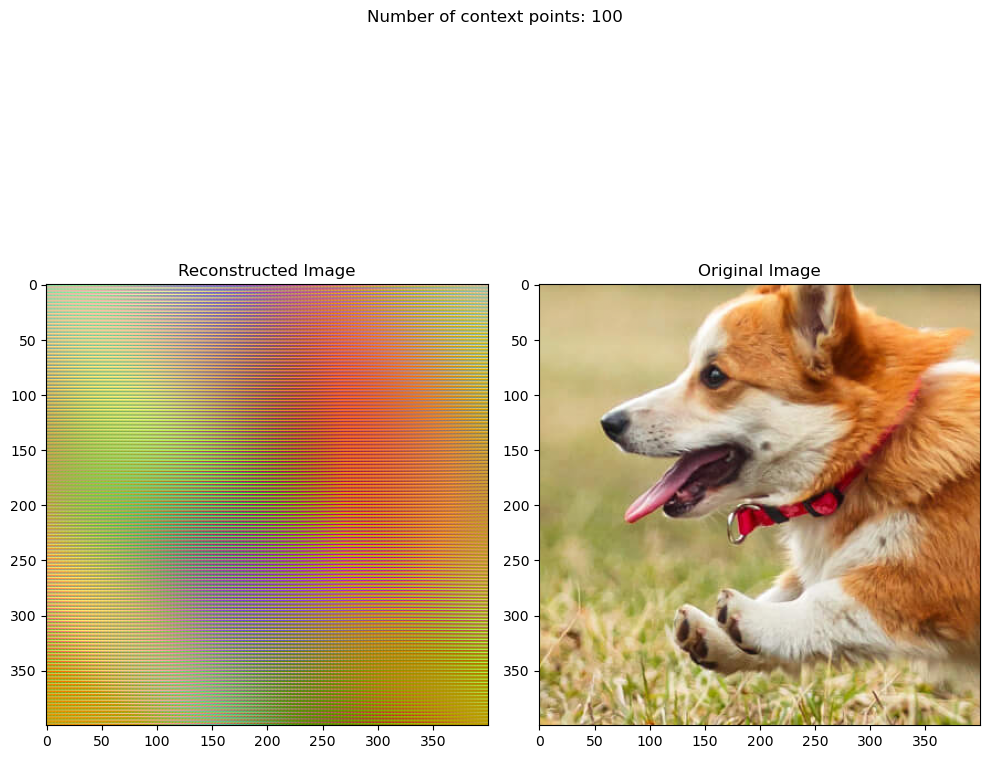

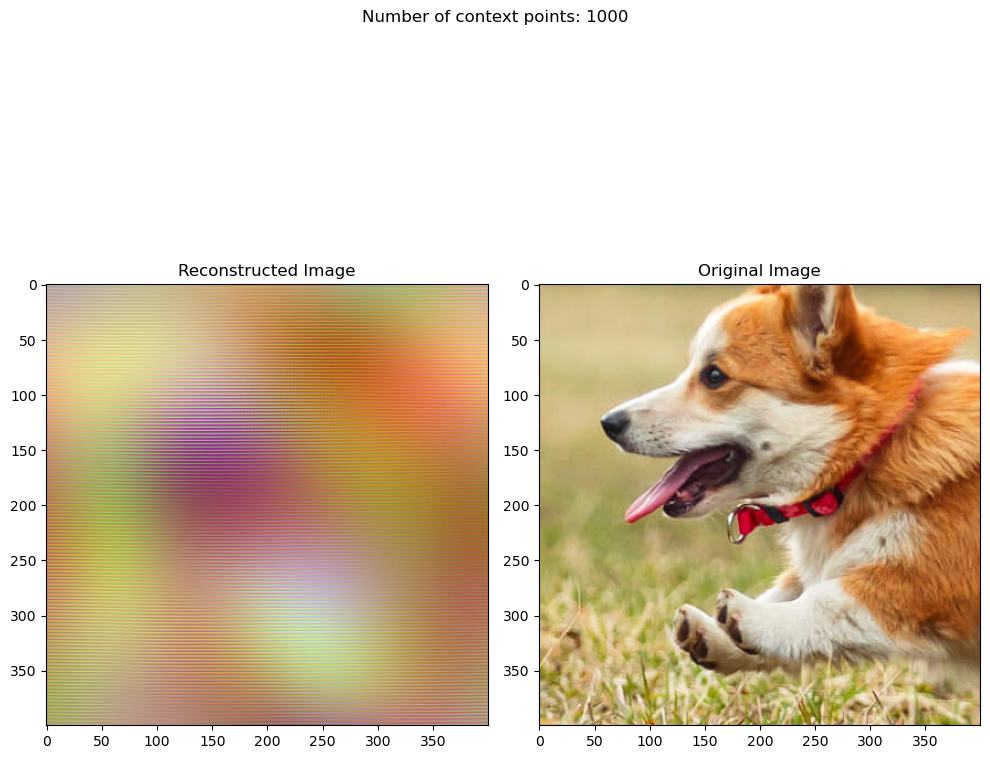

In [142]:
# Plot the reconstructed image for each number of context points

for num_context in context_lengths:
    print(f"Number of context points: {num_context}")
    plot_reconstructed_and_original_image(crop, test_nets_sirens[num_context], dog_X_scaled)
    plt.suptitle(f"Number of context points: {num_context}")
    plt.tight_layout()

In [44]:
from copy import deepcopy

input_data = deepcopy(dog_X)

net = deepcopy(nns["dog"]["relu"])

input_data.requires_grad = True  # Enable gradient computation for the input data
outputs = net(input_data)  # Forward pass

g = torch.autograd.grad(outputs, input_data, grad_outputs=torch.ones_like(outputs), create_graph=True)


In [ ]:
dog_X.shape

torch.Size([160000, 2])

In [1]:
g

NameError: name 'g' is not defined

In [40]:
# Plot the gradient of the network wrt to the input
def plot_gradient(net, img):
    """
    net: torch.nn.Module
    img: torch.Tensor of shape (num_channels, height, width)
    """
    num_channels, height, width = img.shape
    X, Y = create_coordinate_map(img)
    net.eval()
    img.requires_grad = True
    
    # Forward pass
    outputs = net(X)
    loss = nn.MSELoss()(outputs, Y)
    
    # Backward pass
    loss.backward()
    
    # Get the gradients
    grads = img.grad
    
    # Plot the gradients
    plt.imshow(grads.permute(1, 2, 0).abs())
    

plot_gradient(nns["dog"]["relu"], crop)

nns["dog"]["relu"].eval()
dog_X.requires_grad = True

# Forward pass
outputs = nns["dog"]["relu"](dog_X)

loss = nn.MSELoss()(outputs, dog_Y)

# Backward pass
loss.backward()

# Get the gradients
grads = dog_X.grad


AttributeError: 'NoneType' object has no attribute 'permute'

In [35]:
grad.


torch.Size([160000, 2])

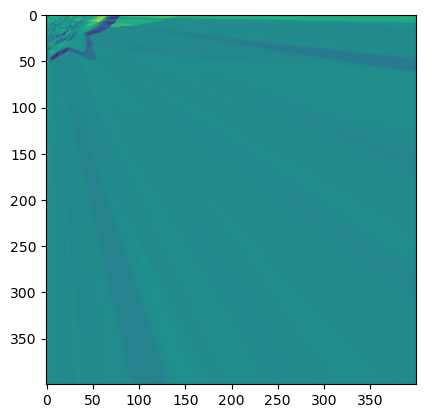

In [38]:
# Reshape the gradients
grad = grads.sum(dim=1).reshape(400, 400)

plt.imshow(grad.cpu())

In [ ]:
from astra.torch.data import load_mnist
ds, ds_name = load_mnist()

In [ ]:
ds

In [ ]:
ds.info()

In [ ]:
images = ds['img'][:100].values

# Convert the NumPy array to a PyTorch tensor
images_tensor = torch.from_numpy(images)

In [ ]:
images_tensor.shape

In [ ]:
# Plot ith image
def plot_image(i):
    plt.imshow(images_tensor[i].reshape(28, 28), cmap='gray')
    # Remove the axis
    plt.axis('off')
    plt.show()

plot_image(0)

In [ ]:
im = images_tensor[0].reshape(28, 28)
im.shape

In [ ]:
xi, yi = torch.meshgrid(torch.arange(28), torch.arange(28))
xi.shape

In [ ]:
xi.reshape(-1, 1).shape

In [ ]:
im.view(-1, 28*28)

In [ ]:
def convert_coordinate(image):
    flat_im = image.view(-1)

    # Create (x, y) coordinate pairs
    x_coords, y_coords = torch.meshgrid(torch.arange(28), torch.arange(28))

    # Flatten the coordinates as well
    # Flatten the coordinates as well
    x_coords = x_coords.reshape(-1)
    y_coords = y_coords.reshape(-1)

    # Stack the (x, y) coordinates with the flattened image
    coordinates = torch.stack((x_coords, y_coords), dim=1)

    return coordinates, flat_im

In [ ]:
convert_coordinate(im)

In [ ]:
# Create a MLP with 5 hidden layers with 256 neurons each and ReLU activations.
# Input is (x, y) and output is (r, g, b) or (g) for grayscale

class NN(nn.Module):
    def __init__(self, activation=torch.sin, n_out=1):
        super().__init__()
        self.activation = activation
        self.fc1 = nn.Linear(2, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 256)
        self.fc6 = nn.Linear(256, n_out) #gray scale image (1) or RGB (3)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.activation(self.fc5(x))
        return self.fc6(x)

In [ ]:
nn_relu = NN(activation=F.relu)

nn_relu.activation

In [ ]:
nn_relu(convert_coordinate(im)[0])

In [ ]:
def train(model, image, epochs=1000, lr=0.01, verbose=True):
    # Convert the image to (x, y) coordinates and pixel values
    coordinates, pixel_values = convert_coordinate(image)

    # Define the loss function
    loss_fn = nn.MSELoss()

    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Train the model
    for i in range(epochs):
        # Forward pass
        pred = model(coordinates)
        print(pred.shape)
        

        # Compute the loss
        loss = loss_fn(pred, pixel_values)

        # Zero the gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update the parameters
        optimizer.step()
        if verbose:
            if i % 100 == 0:
                print(f'Epoch: {i}, Loss: {loss.item():.4f}')

In [ ]:
train(nn_relu, im)